# Fiber Assignment Intro on a simplified mock catalog

This tutorial will teach you:

* The required inputs to fiber assignment.
* How to run `fiberassign` on those.
* How to interpret the fiber assignment output files, including understanding coverage.

This tutorial uses the low level `fba_run`, `fba_merge` scripts.  See https://fiberassign.readthedocs.io/en/latest/ for installation instructions.

In this notebook the inputs to fiberassign are built from a simple mock file with cartesian positions.
We do not include standard stars or sky positions in the assigment, which will be required in the survey 
and will take 10% of the fibers in the focal plane.
The notebooks `FiberAssignDECaLS.ipynb` and `FiberAssignMocks.ipnynb` show how to use inputs from observations and more realistic mock files, respectively.

See https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC for instructions on configuring jupyter kernels with pre-installed DESI software at NERSC.  This tutorial works with either the master kernel or kernels for software releases 19.2 or later.

Jaime Forero-Romero & Stephen Bailey<br/>
June 2019

## Basic python imports

In [1]:
import os, sys, subprocess, shutil
from collections import Counter
import h5py
import matplotlib.pyplot as plt

import numpy as np
from astropy.table import Table
from astropy.io import fits

import desimodel.io
import desimodel.focalplane
import desimodel.footprint
from desitarget.targetmask import desi_mask, bgs_mask, obsconditions

%matplotlib inline


## Create an output directory in $SCRATCH/desi/test/quickmockfiberassign

In [2]:
workdir = os.getenv('SCRATCH') + '/desi/test/quickmockfiberassign'
os.makedirs(workdir, exist_ok=True)
os.chdir(workdir)
outdir = workdir + '/output'
os.makedirs(outdir, exist_ok=True)
shutil.copy(os.path.join(os.getenv('SCRATCH'), 'quickmock', 'sample_mock_redshift_0.hdf5'), workdir)

'/global/cscratch1/sd/forero/desi/test/quickmockfiberassign/sample_mock_redshift_0.hdf5'

# Fiber Assignment inputs

Fiber assignment requires the following input files:

**TODO**: document what each column is

**TODO**: some of these are no longer required in fiberassign 1.0.0; identify and remove those (likely BGS_TARGET, MWS_TARGET, and BRICKNAME).
    
* "Merged Target List" (MTL): FITS file with columns:
  * TARGETID
  * RA
  * DEC
  * DESI_TARGET
  * BGS_TARGET
  * MWS_TARGET
  * PRIORITY
  * SUBPRIORITY
  * BRICKNAME
  * OBSCONDITIONS
  * NUMOBS_MORE
* sky locations; FITS file with columns:
  * TARGETID
  * RA
  * DEC
  * DESI_TARGET
  * BGS_TARGET
  * MWS_TARGET
  * PRIORITY
  * SUBPRIORITY
  * BRICKNAME
  * OBSCONDITIONS

Standard stars can either be in the same file as the science targets, or they can
be in a separate file (with the same required columns).  `fiberassign` uses `DESI_TARGET`
mask bits `STD_FAINT`, `STD_BRIGHT`, and `STD_WD` to determine which targets may be
used as standard stars.

Optional inputs:

* footprint tiles (default `$DESIMODEL/data/footprint/desi-tiles.fits`) with columns
  * TILEID
  * RA
  * DEC
  * PASS
  * OBSCONDITIONS
  * IN_DESI
  * PROGRAM



# Translating a mock with cartesian positions to ra, dec

In [3]:
def get_ra_dec():
    sample = h5py.File("sample_mock_redshift_0.hdf5", 'r')
    sample_x = sample['data']['x']
    sample_y = sample['data']['y']
    sample_z = sample['data']['z']
    sample_Mr = sample['data']['Mr']
    sample_g_r = sample['data']['g_r']
    sample.close()

    new_center = 0.5*(sample_x.max() - sample_x.min())
    x_pos = sample_x - new_center
    y_pos = sample_y - new_center
    z_pos = sample_z - new_center
    r_pos = np.sqrt(x_pos**2 + y_pos**2 + z_pos**2)
    theta = np.rad2deg(np.arccos(z_pos/r_pos))
    phi = np.rad2deg(np.arctan2(y_pos, x_pos)) + 180.0

    ii = r_pos<new_center
    ra = 360.0 - phi[ii]
    dec = 90-theta[ii] 
    return {'RA':ra, 'DEC':dec}

In [4]:
data = get_ra_dec()

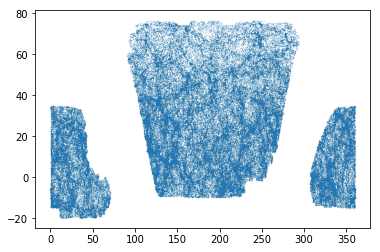

In [5]:
# Trim the targets to the DESI footprint
tiles = desimodel.io.load_tiles()
ii = desimodel.footprint.is_point_in_desi(tiles, data['RA'], data['DEC'])
data['RA'] = data['RA'][ii]
data['DEC'] = data['DEC'][ii]
plt.scatter(data['RA'],data['DEC'], s=0.01, alpha=0.5)


In [6]:
n = len(data['RA'])
print(n)
#- Iterate if needed to get unique TARGETIDs
while True:
    targetids = np.random.randint(0, 2**62-1, n)
    if len(set(targetids)) == n:
        break

#- Create targets table
targets = Table()
targets['TARGETID'] = targetids
targets['RA'] = data['RA']
targets['DEC'] = data['DEC']
targets['PRIORITY'] = bgs_mask.BGS_BRIGHT.priorities['UNOBS']
targets['DESI_TARGET'] = np.zeros(n, dtype='i8')
targets['BGS_TARGET'] = np.zeros(n, dtype='i8') 
targets['MWS_TARGET'] = np.zeros(n, dtype='i8')
targets['SUBPRIORITY'] = np.random.uniform(0, 1, n)
targets['OBSCONDITIONS'] = np.ones(n, dtype='i4') 
targets['NUMOBS_MORE'] = np.ones(n, dtype='i8') 

targets['DESI_TARGET'] = desi_mask.BGS_ANY
targets['BGS_TARGET'] =  bgs_mask.BGS_BRIGHT
targets['OBSCONDITIONS'] = obsconditions.BRIGHT 
targets['NUMOBS_MORE'] = bgs_mask.BGS_BRIGHT.numobs
targets.meta['EXTNAME'] = 'MTL'
targets.write('mtl.fits', overwrite=True)

211458


In [7]:
# tile selection
tiles = desimodel.io.load_tiles()
ii = (tiles['PROGRAM']=='BRIGHT')  & (tiles['PASS']==5)
Table(tiles[ii]).write('tiles.fits', overwrite=True)
print(len(tiles[ii]))

2007


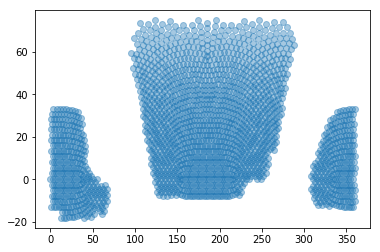

In [8]:
fa_tiles = Table.read('tiles.fits')
plt.scatter(fa_tiles['RA'], fa_tiles['DEC'], alpha=0.4)

In [9]:
cmd = 'fba_run --overwrite --targets mtl.fits '
cmd += ' --footprint ./tiles.fits'
cmd += ' --dir ./output/'
print(cmd)
print('RUNNING: '+cmd)
err = subprocess.call(cmd.split())
assert err == 0

fba_run --overwrite --targets mtl.fits  --footprint ./tiles.fits --dir ./output/
RUNNING: fba_run --overwrite --targets mtl.fits  --footprint ./tiles.fits --dir ./output/


In [10]:
cmd = 'fba_merge_results --targets mtl.fits  --dir ./output/'
print('RUNNING: '+cmd)
err = subprocess.call(cmd.split())
assert err == 0

RUNNING: fba_merge_results --targets mtl.fits  --dir ./output/


## fiberassign output

`fiberassign` output files contain the following HDUs:
* `FIBERASSIGN`: fiber assignments for the 5000 positioners with fibers connected to a spectrograph
* `POTENTIAL_ASSIGNMENTS`: a table of what targets were covered by what fibers, whether or not they were assigned
* `SKY_MONITOR`: assignments of the 20 fibers that go to the sky monitor camera (not the spectrographs)
* `TARGETS`: (deprecated) a copy of the input targets table with all columns

The latest version of fiberassign also has HDUS `FASSIGN`, `FTARGETS`, and `FAVAIL`, which we won't cover here (yet).

In [11]:
tilefile = '{}/tile-{:06d}.fits'.format(outdir, fa_tiles['TILEID'][0])
fx = fits.open(tilefile)
print(fx.info())
print('\nFIBERASSIGN columns:')
print(fx['FIBERASSIGN'].data.dtype.names)
print('\nPOTENTIAL_ASSIGNMENTS columns:')
print(fx['POTENTIAL_ASSIGNMENTS'].data.dtype.names)
fx.close()

Filename: /global/cscratch1/sd/forero/desi/test/quickmockfiberassign/output/tile-028814.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   ()      
  1  FIBERASSIGN    1 BinTableHDU     67   5000R x 25C   [J, J, I, K, K, B, D, D, E, E, 8A, J, E, E, E, 3A, I, J, J, D, J, J, K, K, K]   
  2  SKY_MONITOR    1 BinTableHDU     51   20R x 17C   [J, J, I, K, K, B, D, D, E, E, 8A, J, E, E, I, J, J]   
  3  TARGETS       1 BinTableHDU     67   55R x 25C   [J, J, I, K, K, B, D, D, E, E, 8A, J, E, E, E, 3A, I, J, J, D, J, J, K, K, K]   
  4  POTENTIAL_ASSIGNMENTS    1 BinTableHDU     23   68R x 3C   [K, J, J]   
  5  FASSIGN       1 BinTableHDU     49   5020R x 16C   [J, K, J, J, E, I, J, 3A, D, D, K, B, E, E, E, E]   
  6  FTARGETS      1 BinTableHDU     35   55R x 9C   [K, D, D, K, B, J, D, J, J]   
  7  FAVAIL        1 BinTableHDU     23   68R x 3C   [J, J, K]   
None

FIBERASSIGN columns:
('FIBER', 'LOCATION', 'NUMTARGET', 'TARGETID', 

## Which targets were assigned?

In [12]:
assignments = list()
for tileid in fa_tiles['TILEID']:
    tilefile = '{}/tile-{:06d}.fits'.format(outdir, tileid)
    assignments.append(Table.read(tilefile, 'FIBERASSIGN'))

In [13]:
assigned_targetids = np.concatenate([tmp['TARGETID'] for tmp in assignments])
isAssigned = np.in1d(targets['TARGETID'], assigned_targetids)

Text(0.5,1,'Targets assigned to fibers')

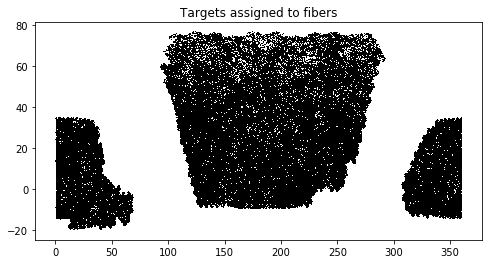

In [17]:
plt.figure(figsize=(8,4))
plt.plot(targets['RA'][isAssigned], targets['DEC'][isAssigned], 'k,')
plt.title('Targets assigned to fibers')
# plot_tiles(tiles)

## And which targets weren't assigned?

Text(0.5,1,'Targets not assigned to fibers')

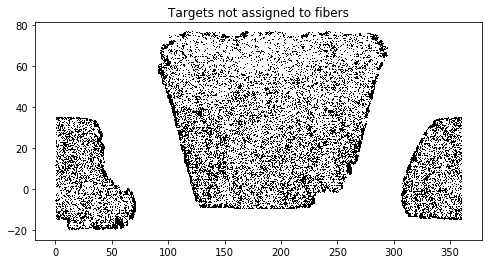

In [18]:
plt.figure(figsize=(8,4))
plt.plot(targets['RA'][~isAssigned], targets['DEC'][~isAssigned], 'k,')
plt.title('Targets not assigned to fibers')

Let's compare the number that were assigned to the simple estimate of counting fibers.
For this density of targets, nearly all fibers are assigned to a target.
i.e. if a target wasn't assigned, it was because either it wasn't covered by a fiber at all,
or because that fiber was given to a different target instead.  Good.

In [19]:
num_assigned = np.count_nonzero(isAssigned)
max_possible_assigned = int(len(tiles) * 5000)  
print('Targets assigned        ', num_assigned)
print('Max possible assignments', max_possible_assigned)
print('Ratio                   ', num_assigned/max_possible_assigned)

Targets assigned         182514
Max possible assignments 80355000
Ratio                    0.0022713459025574013


### Histogram how many times each target was assigned

In [20]:
def get_assigned_covered(tiles):
    assigned_ids = list()
    covered_ids = list()
    for tileid in tiles['TILEID']:
        tilefile = '{}/tile-{:06d}.fits'.format(outdir, tileid)
        assignments = Table.read(tilefile, 'FIBERASSIGN')
        assigned_ids.extend(assignments['TARGETID'])

        #- Note: a single target could be covered by more than one fiber on the same
        #- tile, but it still can only be assigned once, so use np.unique() per tile
        #- to not double count those cases
        potential = Table.read(tilefile, 'POTENTIAL_ASSIGNMENTS')
        covered_ids.extend(np.unique(potential['TARGETID']))

    #- Trim to just science targets (i.e. not SKY, not non-science STDSTAR)
    assigned_ids = np.array(assigned_ids)
    ii = np.in1d(assigned_ids, targets['TARGETID'])
    assigned_ids = assigned_ids[ii]

    covered_ids = np.array(covered_ids)
    ii = np.in1d(covered_ids, targets['TARGETID'])
    covered_ids = covered_ids[ii]

    return assigned_ids, covered_ids

#- Do a bit of counting magic to include targets that were never assigned or covered
def count_coverage(ids):
    c = Counter(ids)
    c.update(targets['TARGETID'])
    count = np.array(list(c.values())) - 1
    return count

In [21]:
assigned_ids, covered_ids = get_assigned_covered(fa_tiles)
assigned_count = count_coverage(assigned_ids)
covered_count = count_coverage(covered_ids)

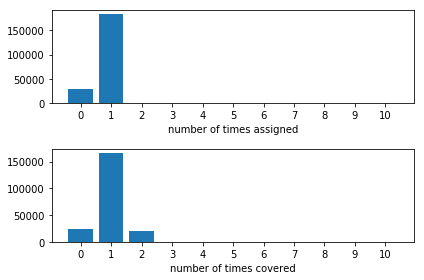

In [23]:
plt.subplot(211)
_=plt.hist(assigned_count, 11, (-0.5, 10.5), rwidth=0.8)
plt.xticks(np.arange(0,11))
plt.xlabel('number of times assigned')

plt.subplot(212)
plt.hist(covered_count, 11, (-0.5, 10.5), rwidth=0.8)
plt.xticks(np.arange(0,11))
plt.xlabel('number of times covered')

plt.tight_layout()